## Introduction

In any other year, I would have probably borrowed a [Basys 3
FPGA](https://store.digilentinc.com/basys-3-artix-7-fpga-trainer-board-recommended-for-introductory-users/)
from the school to take computer architecture. However,
due to the pandemic, I had to _spend money_ and buy it myself.
That thing is $150 - it ain't cheap!

Now that class is over, I had this board and I wanted to do
something with it. But I didn't want to do something that any
ordinary microcontroller could do. No, that's boring, I would
just use a microcontroller. No, I wanted something that only a
FPGA could do.

So, I thought of making a direct sampling software-defined
radio. It won't have a transmit function, only a receive
function, because I have no idea how to do power electronics.
Its main purpose would be basically as an ultra
wide band scanner (I'm thinking of trying to make it scan
a 50 MHz section all at once).

I'm jumping into this project with zero formal knowledge
about digital signal processing other than some basics like
"oh look this is what a low pass, high pass, band pass,
notch, and FFT do, and convolution is a thing!" I've done
a good amount of planning, and it seems somewhat viable. This
post is basically just me testing out the viability on a
fake signal.

## Problem parameters

The FPGA has a **100 MHz internal clock** for most computations, and I
want to scan the spectrum of frequencies **between 125 and 175 MHz.**
Therefore, by the Nyquist-Shannon theorem, I will need at least
twice that - 325 MSPS (million samples per second) coming in.

I've figured out a possible way to get **400 MSPS at an 8 bit
resolution** into the FPGA (to be elaborated on in the future, we'll just
assume for now that that's the data stream coming in. So, every 100 MHz
clock, we get 4 x 8-bit samples. We are dealing with a theoretical
data rate of 3.2 Gbps.

Now, when we're doing wideband scanning, we will use FFT so that we can
see what frequencies are active. We can't just do a FFT on the entire
spectrum, though. Let's just say we were doing a 8192 bin FFT on the
entire spectrum. This would mean each bin will be
$\frac{200\text{MHz}}{8192} = 24.41 \text{kHz}$ wide. In my professor's
words, "those are chunky bins." Plus, we really only care about 125-175MHz.
We will be getting a bunch of data that we don't really want!

So, prior to performing the FFT, we will need to "zoom in" on the
125-175MHz section, and that's what this Jupyter notebook is for. Yes,
a Jupyter notebook! I'm writing this blog post in a Jupyter notebook
because ya girl is fancy like that.

## Generating a "raw signal"

Let's make a simple signal that we can use for experimenting with.

In [2]:
import numpy as np

SAMPLES_PER_SECOND = 400e6
NYQUIST = SAMPLES_PER_SECOND / 2
SIGNAL_LENGTH = 10e-3

# Time domain (1 index = 1 sample at 400 MSPS)
time = np.linspace(0, SIGNAL_LENGTH, SIGNAL_LENGTH * SAMPLES_PER_SECOND)

def tone(x):
    return np.cos(x * time * 2 * np.pi)

def fm_tone(x, carrier, deviation):
    return np.cos(carrier * time * 2 * np.pi + deviation * np.sin(x * time * 2 * np.pi))

def am_tone(x, carrier):
    return (1 + np.cos(x * time * 2 * np.pi)) * np.cos(carrier * time * 2 * np.pi)

received_signal = 5 * tone(125e6)
received_signal += 5 * tone(175e6)
received_signal += 10 * am_tone(5e3, 150e6)
received_signal += fm_tone(100e3, 135e6, 0.25)

# Add in some unwanted tones
received_signal += 5 * tone(100e6)
received_signal += 100 * tone(120e6)
received_signal += 0.5 * fm_tone(800, 180e6, 4e3)
received_signal += 4 * fm_tone(250, 50e6, 1e5)

# An increasing frequency tone to act as an indicator
received_signal += 3 * np.cos((time * 100e6 / SIGNAL_LENGTH) * time * 2 * np.pi)

# Add in some noise for the heck of it
received_signal += np.random.normal(0, 1, len(time))

In [3]:
import matplotlib.pyplot as plt

# So that y'all actually see this stuff
plt.rcParams['figure.figsize'] = [8, 5]

plt.specgram(received_signal, 4096, 400)

plt.title("Full signal")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

<Figure size 800x500 with 1 Axes>

We currently have a signal with frequencies from 0-200MHz. However,
we only want to focus on the 125-175MHz range so that our FFT can be.
at least somewhat more precise.

## Shifting the signal downwards

First, we apply a bandpass filter with cutoffs at 120MHz and 180MHz. They
are somewhat offset from the frequencies we want so that we have a little
buffer space at the ends.

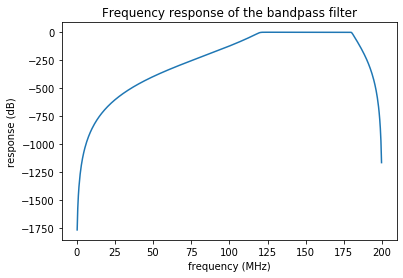

In [4]:
from scipy import signal

bp_filter = signal.butter(
    32,
    [120e6 / NYQUIST, 180e6 / NYQUIST],
    'band',
    analog=False,
    output='sos'
)
w, h = signal.sosfreqz(bp_filter, fs=400)
plt.plot(w, 20 * np.log10(abs(h)))
plt.title("Frequency response of the bandpass filter")
plt.ylabel('response (dB)')
plt.xlabel('frequency (MHz)')
plt.show()

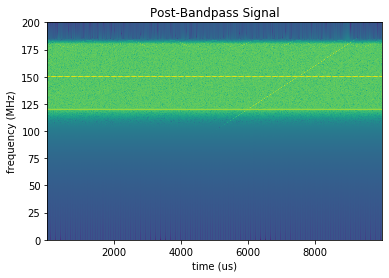

In [5]:
bp_sig = signal.sosfilt(bp_filter, received_signal)
plt.specgram(bp_sig, 4096, 400)
plt.title("Post-Bandpass Signal")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

Next, we mix with a 115MHz signal. For a signal with frequency $f$, this should
produce two signals, one at $f - 115\text{MHz}$, and the other reflected
at $115\text{MHz} - (f - 115\text{MHz})$.

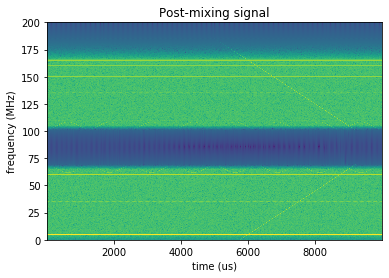

In [6]:
mixed = bp_sig * np.cos(115e6 * 2 * np.pi * time)

plt.specgram(mixed, 4096, 400)
plt.title("Post-mixing signal")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

We now perform a low pass to get rid of that pesky evil twin up there.
The 10-60MHz range here is the equivalent of the original's 125-175MHz range.

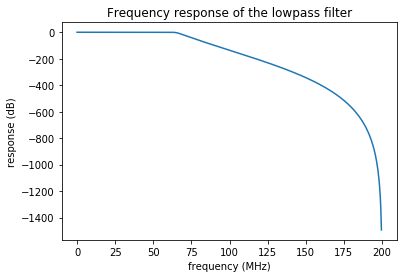

In [7]:
lp_filter = signal.butter(
    27,
    65e6 / NYQUIST,
    'lowpass',
    output='sos'
)
w, h = signal.sosfreqz(lp_filter, fs=400)
plt.plot(w, 20 * np.log10(abs(h)))
plt.title("Frequency response of the lowpass filter")
plt.ylabel('response (dB)')
plt.xlabel('frequency (MHz)')
plt.show()

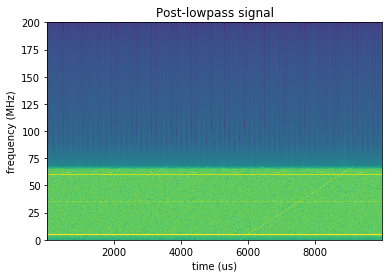

In [8]:
lp_sig = signal.sosfilt(lp_filter, mixed)
plt.specgram(lp_sig, 4096, 400)
plt.title("Post-lowpass signal")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

Finally, we decimate to get rid of what we don't want. Decimating by a
factor of 3 means that the frequencies included here are between 0-67MHz
post-mixing, which is 120-177MHz on the original.

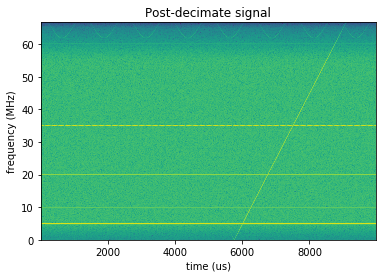

Bin size: 16.276 kHz


In [12]:
decimate = signal.decimate(lp_sig, 3)
plt.specgram(decimate, 4096, 400 / 3)
plt.title("Post-decimate signal")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

print(f'Bin size: {1000 * (400 / 3) / 2 / 4096:02.3f} kHz')

You can see how the sub-120 MHz signals get aliased in by the "checkmark"
over the 1500 tick. This is why we want padding below 125MHz and above
175MHz. However, the aliasing stays below 10 MHz on this spectrogram (125 MHz
on the original). So, we'll just zoom in on the center and pretend the
upper and lower bands don't exist and pretend the
axes are the correct "original" values.

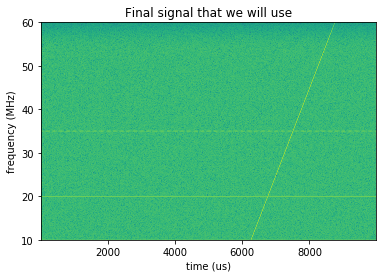

In [10]:
plt.specgram(decimate, 4096, 400 / 3)
plt.ylim([10, 60])
plt.title("Final signal that we will use")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

## Conclusion

